In [1]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import mne
import os

# Define the directory containing the `.fif` files
#data_dir = r"C:\Users\A495502\OneDrive - Volvo Group\01Study\00LTU\d7064e\project\EEGproc"

# List all `.fif` files in the directory
#files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".fif")]

# Function to load and inspect the data
def load_and_inspect_fif(file_path):
    print(f"Loading file: {file_path}")
    # Load the data
    epochs = mne.read_epochs(file_path, preload=True)

    # Inspect basic info
    print(epochs.info)
    print(f"Number of epochs: {len(epochs)}")
    print(f"Channel names: {epochs.ch_names}")
    print(f"Sampling frequency: {epochs.info['sfreq']} Hz")

    # Get data and labels
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    labels = epochs.events[:, -1]  # Labels for each epoch

    print(f"Data shape: {data.shape}")
    print(f"Labels shape: {labels.shape}")

    return epochs, data, labels



In [4]:
pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 4.8 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import mne

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif, SelectPercentile, VarianceThreshold
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the directory containing the `.fif` files
# data_dir = r"C:\Users\A495502\OneDrive - Volvo Group\01Study\00LTU\d7064e\project\EEGproc"

# List all `.fif` files in the directory
#file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".fif")]
file_paths = [
    "/content/drive/MyDrive/subject01_session01_eeg-epo.fif",
    "/content/drive/MyDrive/subject02_session01_theta_eeg-epo.fif",
    "/content/drive/MyDrive/subject03_session01_delta_eeg-epo.fif",
    "/content/drive/MyDrive/subject05_session01_theta_eeg-epo.fif"
]

file_path = "/content/drive/MyDrive/subject01_session01_eeg-epo.fif"

# Function to load EEG data and labels
def load_data(file_path):
    data_list = []
    labels_list = []

    print(f"Loading file: {file_path}")
    epochs = mne.read_epochs(file_path, preload=True)
    # epochs = epochs.crop(tmin=-0.2, tmax=0.8)
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

    labels = epochs.events[:, -1]  # Labels corresponding to epochs
    data_list.append(data)
    labels_list.append(labels)
    # Combine data from all files
    X = np.concatenate(data_list, axis=0)  # Combine along the epochs axis
    y = np.concatenate(labels_list, axis=0)
    return X, y

# Load data
X, y = load_data(file_path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


Using device: cpu
Loading file: /content/drive/MyDrive/subject01_session01_eeg-epo.fif
Reading /content/drive/MyDrive/subject01_session01_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated


In [11]:
# Define SNN Model
class SNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lif1 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.lif2 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk1, mem1 = self.lif1(self.fc1(x), mem1)
        spk2, mem2 = self.lif2(self.fc2(spk1), mem2)
        return spk2, mem2

# Model parameters
input_dim = 1769  # Number of features (n_channels * n_times)
hidden_dim = 128
output_dim = 8
# Instantiate the model
snn_model = SNN(input_dim, hidden_dim, output_dim)

# Define optimizer and loss function
optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
import matplotlib.pyplot as plt

In [20]:
def train_loop(train_loader):
  # Instantiate the model and move to GPU
  snn_model = SNN(input_dim, hidden_dim, output_dim)

  # Define optimizer and loss function
  optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  # Training Loop
  epochs = 20
  train_losses = []
  train_accuracies = []

  for epoch in range(epochs):
      snn_model.train()
      train_loss = 0
      correct_train = 0
      total_train = 0

      for batch_x, batch_y in train_loader:
          optimizer.zero_grad()
          batch_x = batch_x
          batch_y = batch_y
          spk_out, _ = snn_model(batch_x)
          loss = criterion(spk_out, batch_y)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          # Compute training accuracy for the current batch
          _, predicted = torch.max(spk_out, 1)
          total_train += batch_y.size(0)
          correct_train += (predicted == batch_y).sum().item()

      # Calculate average loss and accuracy for the epoch
      avg_loss = train_loss / len(train_loader)
      train_accuracy = correct_train / total_train * 100

      train_losses.append(avg_loss)
      train_accuracies.append(train_accuracy)

      print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
  return snn_model

def test_acc(test_loader, snn_model):
  snn_model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch_x, batch_y in test_loader:
          spk_out, _ = snn_model(batch_x)
          _, predicted = torch.max(spk_out, 1)
          total += batch_y.size(0)
          correct += (predicted == batch_y).sum().item()
          print(predicted)

  accuracy = correct / total * 100
  print(f"Test Accuracy: {accuracy:.2f}%")
  return accuracy



In [21]:
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
overall_eeg_score = []
for train_index, test_index in kf.split(X, y_encoded):
  scaler = Normalizer(norm='l2')
  print("Indexes are", train_index, test_index)

        # Split the EEG and fMRI data using the indices provided by KFold
  X_train, X_test = X[train_index], X[test_index]

  y_train, y_test = y_encoded[train_index], y_encoded[test_index]

# L2 normalize the EEG data
  eegX_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
  eegX_test = scaler.fit_transform(np.reshape(X_test, (X_test.shape[0], -1)))


# Make pipelines for EEG and fMRI
  eeg_feature_selection = SelectPercentile(f_classif, percentile=2)
  std_scaler = StandardScaler()
  eegX_train = std_scaler.fit_transform(eegX_train)
  eegX_test = std_scaler.fit_transform(eegX_test)

  X_train = eeg_feature_selection.fit_transform(eegX_train, y_train)
  X_test = eeg_feature_selection.transform(eegX_test)

  # eeg_clf_percentile = make_pipeline(StandardScaler(), eeg_feature_selection,
  #                                  RandomForestClassifier(n_estimators=100, random_state=42))
  # Convert to PyTorch tensors and move to GPU if available
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)

  # Create DataLoader
  batch_size = 64
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  snn_model = train_loop(train_loader)
  acc = test_acc(test_loader, snn_model)
  overall_eeg_score.append(acc)

Indexes are [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  38  39  40  41  42  44  45  46  47  48  50  52  53  54  55  56  57  58
  59  60  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 126 127 128 129 130 131 133 134
 135 136 137 138 140 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 158 160 161 162 163 164 165 166 167 169 170 171 172 173 174 175
 176 177 178 180 182 183 185 186 188 189 190 191 192 194 195 196 197 198
 199 200 201 202 203 204 206 207 208 210 211 212 213 214 215 216 217 218
 219 220 222 223 224 225 226 227 228 230 231 233 235 236 237 238 239 240
 241 242 243 244 246 247 248 249 250 251 252 253 254 255 256 257 258 260
 261 262 263 264 266 267 268 269 270 27

In [22]:
# non-feature selection
overall_eeg_score

[25.0, 25.0, 40.625, 21.875, 25.0, 15.625, 15.625, 12.5, 21.875, 15.625]

In [23]:
np.array(overall_eeg_score).mean()

21.875

# All subjects

In [24]:
def snn_train(file_path):
  # Load data
  X, y = load_data(file_path)

  # Encode labels
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
  overall_eeg_score = []
  for train_index, test_index in kf.split(X, y_encoded):
    scaler = Normalizer(norm='l2')
    print("Indexes are", train_index, test_index)

          # Split the EEG and fMRI data using the indices provided by KFold
    X_train, X_test = X[train_index], X[test_index]

    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

  # L2 normalize the EEG data
    eegX_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
    eegX_test = scaler.fit_transform(np.reshape(X_test, (X_test.shape[0], -1)))


  # Make pipelines for EEG and fMRI
    eeg_feature_selection = SelectPercentile(f_classif, percentile=2)
    std_scaler = StandardScaler()
    eegX_train = std_scaler.fit_transform(eegX_train)
    eegX_test = std_scaler.fit_transform(eegX_test)

    X_train = eeg_feature_selection.fit_transform(eegX_train, y_train)
    X_test = eeg_feature_selection.transform(eegX_test)

    # eeg_clf_percentile = make_pipeline(StandardScaler(), eeg_feature_selection,
    #                                  RandomForestClassifier(n_estimators=100, random_state=42))
    # Convert to PyTorch tensors and move to GPU if available
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader
    batch_size = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    snn_model = train_loop(train_loader)
    acc = test_acc(test_loader, snn_model)
    overall_eeg_score.append(acc)
  return overall_eeg_score


In [25]:
file_paths

['/content/drive/MyDrive/subject01_session01_eeg-epo.fif',
 '/content/drive/MyDrive/subject02_session01_theta_eeg-epo.fif',
 '/content/drive/MyDrive/subject03_session01_delta_eeg-epo.fif',
 '/content/drive/MyDrive/subject05_session01_theta_eeg-epo.fif']

In [26]:
avg_10fold_score = []
for file_path in file_paths:
  overall_eeg_score = np.array(snn_train(file_path)).mean()
  avg_10fold_score.append(overall_eeg_score)


Loading file: /content/drive/MyDrive/subject01_session01_eeg-epo.fif
Reading /content/drive/MyDrive/subject01_session01_eeg-epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated
Indexes are [  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  38  39  40  41  42  44  45  46  47  48  50  52  53  54  55  56  57  58
  59  60  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 126 127 128 129 130 131 133 134
 135 136 137 138 140 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 158 160 161 162 163 164

In [27]:
avg_10fold_score

[21.25, 18.125, 11.875, 19.924242424242426]

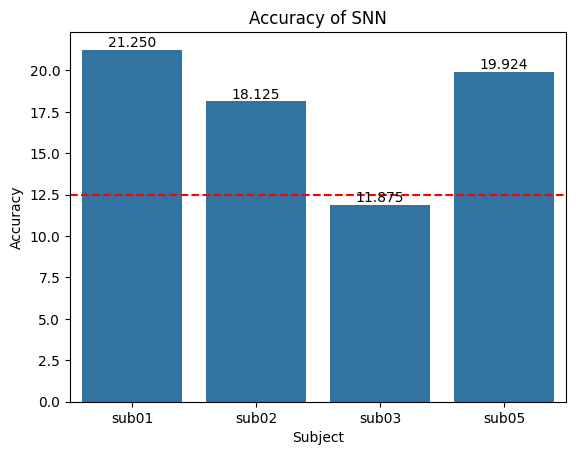

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
# Data to be plotted
data = avg_10fold_score

# Labels for the bars
labels = ['sub01', 'sub02', 'sub03', 'sub05']

# Create a bar plot using seaborn
sns.barplot(x=labels, y=data)

# Add title and labels to the plot
plt.title('Accuracy of SNN')
plt.xlabel('Subject')
plt.ylabel('Accuracy')

# Add a horizontal dashed line at 0.125
plt.axhline(y=12.5, color='r', linestyle='--')

# Add the values to the top of each bar
for i, v in enumerate(data):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom')

# Show the plot
plt.show()